# Convergence of optimistic no-regret algorithms

## Imports

In [14]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

## Players

In [15]:
# Hedge and optimistic hedge players

class Parent_MWU:
    def __init__(self, K, T, N, min_payoff, max_payoff):
        self.K = K
        self.weights = np.ones(K)
        self.T = T
        self.N = N
        self.min_payoff = min_payoff
        self.max_payoff = max_payoff
        # learning rate from Fast Convergence of Regularized Learning in Games [Syrgkanis et al. 2015]
        # self.gamma_t = 0.1
        
        # This learning rate works better in practice
        self.gamma_t = 1

    def mixed_strategy(self):
        return self.weights / np.sum(self.weights)

    def semi_Update(self, losses):
        self.weights = np.multiply(self.weights, np.exp(np.multiply(self.gamma_t, -losses)))
        self.weights = self.weights / np.sum(
            self.weights)  # To avoid numerical errors when the weights become too small

        
# Hedge algorithm (Freund and Schapire. 1997)
class Player_MWU(Parent_MWU):
    def __init__(self, K, T, N, min_payoff, max_payoff):
        super().__init__(K, T, N, min_payoff, max_payoff)
        self.type = "MWU"
        # adversarial hedge learning rate
        # self.gamma_t = np.sqrt(np.log(self.K) / self.T)

    def Update(self, payoffs):
        payoffs = normalize(payoffs, self.min_payoff, self.max_payoff)
        losses = np.ones(self.K) - np.array(payoffs)
        super().semi_Update(losses)


class Player_OPT_MWU(Parent_MWU):  # Optimistic Hedge algorithm
    def __init__(self, K, T, N, min_payoff, max_payoff):
        super().__init__(K, T, N, min_payoff, max_payoff)
        self.type = "OPT_MWU"
        # learning rate from Near-Optimal No-Regret Learning in General Games [Daskalakis et al. 2021]
        # self.gamma_t = 1 / (2 * self.N * np.log(self.T + 2) ** 4)

    def Update(self, payoffs_t, payoffs_t_1):
        payoffs_t = normalize(payoffs_t, self.min_payoff, self.max_payoff)
        payoffs_t_1 = normalize(payoffs_t_1, self.min_payoff, self.max_payoff)
        loss_t = np.ones(self.K) - payoffs_t
        loss_t_1 = np.ones(self.K) - payoffs_t_1
        losses = 2 * loss_t - loss_t_1
        super().semi_Update(losses)

In [16]:
# GPMW and optimistic GPMW players
# Note: In practice GP_predicted values lie outside the range and the loss vector is usually 0

class Parent_GPMW:
    def __init__(self, K, T, N, min_payoff, max_payoff, sigma, all_action_profiles, payoff_matrix,
                 kernel_optimization=False):
        self.K = K
        self.T = T
        self.N = N
        self.weights = np.ones(K)
        self.UCB_Matrix = np.zeros([K] * N)
        self.gamma_t = 1
        # beta from No-Regret Learning in Unknown Games with Correlated Payoffs [Sessa et al. 2019]
        self.beta_t = 2.0
        self.sigma = sigma
        self.min_payoff = min_payoff
        self.max_payoff = max_payoff

        self.kernel = RBF()
        self.gpr = GaussianProcessRegressor(kernel=self.kernel, alpha=sigma ** 2)
        if kernel_optimization:
            self.gpr.fit(all_action_profiles, np.ndarray.flatten(payoff_matrix))
            self.kernel = self.gpr.kernel_
        else:
            self.gpr.optimizer = None

        self.kernel_matrix = RBF.__call__(self.kernel, all_action_profiles)
        self.mean_matrix = 0 * np.ones(K ** N)
        self.var_matrix = np.zeros(K ** N)
        self.all_action_profiles = all_action_profiles
        for idx in range(K ** N):
            self.var_matrix[idx] = np.array(self.kernel_matrix[idx, idx])
        self.std_matrix = np.sqrt(self.var_matrix)

    def mixed_strategy(self):
        return self.weights / np.sum(self.weights)

    def GP_update(self, history_actions, history_payoffs, recursive_update=True):
        if not recursive_update:
            self.gpr.fit(history_actions, history_payoffs)
            mean_prediction, std_prediction = self.gpr.predict(self.all_action_profiles, return_std=True)
            mean_prediction = np.array(mean_prediction).reshape([self.K] * self.N)
            std_prediction = np.array(std_prediction).reshape([self.K] * self.N)
            self.UCB_Matrix = mean_prediction + self.beta_t * std_prediction
            
        # recursive formula from Appendix F. On Kernelized Multi-armed Bandits [Chowdhury and Gopalan 2017]
        else:
            self.UCB_Matrix = np.ndarray.flatten(self.UCB_Matrix)
            mean_matrix_prev = np.array(self.mean_matrix)
            var_matrix_prev = np.array(self.var_matrix)
            kernel_matrix_prev = np.array(self.kernel_matrix)

            mean_matrix = np.zeros(self.K ** self.N)
            var_matrix = np.zeros(self.K ** self.N)

            idx_t = np.squeeze(np.where(np.all(self.all_action_profiles == history_actions[-1], axis=1)))
            for idx in range(self.all_action_profiles.shape[0]):
                mean_matrix[idx] = mean_matrix_prev[idx] + (kernel_matrix_prev[idx, idx_t] /
                                                            (self.sigma ** 2 + var_matrix_prev[idx_t])) * (
                                           history_payoffs[-1] - mean_matrix_prev[idx_t])
                var_matrix[idx] = var_matrix_prev[idx] - (kernel_matrix_prev[idx, idx_t] ** 2) / (
                        self.sigma ** 2 + var_matrix_prev[idx_t])

                self.UCB_Matrix[idx] = mean_matrix[idx] + self.beta_t * np.sqrt(var_matrix[idx])

            kernel_matrix = kernel_matrix_prev - np.outer(kernel_matrix_prev[:, idx_t],
                                                          kernel_matrix_prev[idx_t, :]) * (
                                    1 / (self.sigma ** 2 + var_matrix_prev[idx_t]))

            self.var_matrix = var_matrix
            self.std_matrix = np.sqrt(var_matrix)
            self.mean_matrix = mean_matrix
            self.kernel_matrix = kernel_matrix
            self.UCB_Matrix = self.UCB_Matrix.reshape([self.K] * self.N)

    def semi_Update(self, losses):
        self.weights = np.multiply(self.weights, np.exp(np.multiply(self.gamma_t, -losses)))
        self.weights = self.weights / np.sum(
            self.weights)


class Player_GPMW(Parent_GPMW):
    def __init__(self, K, T, N, min_payoff, max_payoff, sigma, all_action_profiles, payoff_matrix, kernel_optimization=False):
        super().__init__(K, T, N, min_payoff, max_payoff, sigma, all_action_profiles, payoff_matrix, kernel_optimization)
        self.type = "GPMW"
        # beta from No-Regret Learning in Unknown Games with Correlated Payoffs [Sessa et al. 2019]
        self.gamma_t = np.sqrt(8*np.log(self.K)/self.T)

    def Update(self, payoffs):
        payoffs = normalize(payoffs, self.min_payoff, self.max_payoff)
        losses = np.ones(self.K) - np.array(payoffs)
        super().semi_Update(losses)


class Player_OPT_GPMW(Parent_GPMW):
    def __init__(self, K, T, N, min_payoff, max_payoff, sigma, all_action_profiles, payoff_matrix, kernel_optimization=False):
        super().__init__(K, T, N, min_payoff, max_payoff, sigma, all_action_profiles, payoff_matrix, kernel_optimization)
        self.type = "OPT_GPMW"
        # beta same as vanilla GPMW
        self.gamma_t = np.sqrt(8*np.log(self.K)/self.T)

    def Update(self, payoffs_t, payoffs_t_1):
        payoffs_t = normalize(payoffs_t, self.min_payoff, self.max_payoff)
        payoffs_t_1 = normalize(payoffs_t_1, self.min_payoff, self.max_payoff)
        loss_t = np.ones(self.K) - payoffs_t
        loss_t_1 = np.ones(self.K) - payoffs_t_1
        losses = 2 * loss_t - loss_t_1
        super().semi_Update(losses)

In [17]:
# EXP3.P and optimistic EXP3.P players

class Parent_EXP3:
    def __init__(self, K, T, min_payoff, max_payoff):
        self.K = K
        self.T = T
        self.weights = np.ones(K)
        self.min_payoff = min_payoff
        self.max_payoff = max_payoff
        self.rewards_est = np.zeros(K)
        # params from Theorem 3.2 of Regret Analysis of Stochastic and Nonstochastic Multi-armed Bandit Problems
        # [Bubeck and Cesa-Bianchi 2012]
        self.gamma = 1.05 * np.sqrt(np.log(self.K) * self.K / self.T)
        delta = 0.01
        self.beta = np.sqrt(np.log(self.K * (1 / delta)) / (self.T * self.K))
        self.eta = 0.95 * np.sqrt(np.log(self.K) / (self.T * self.K))
        assert self.beta > 0 and self.beta < 1 and self.gamma > 0 and self.gamma < 1

    def mixed_strategy(self):
        return self.weights / np.sum(self.weights)

    def semi_Update(self, played_a, payoff, recency_bias):
        payoff = normalize(payoff, self.min_payoff, self.max_payoff)
        prob = self.weights[played_a] / np.sum(self.weights)
        self.rewards_est += recency_bias * self.beta * np.divide(np.ones(self.K), self.weights / np.sum(self.weights))
        self.rewards_est[played_a] += recency_bias*(payoff / prob)
        self.weights = np.exp(np.multiply(self.eta, self.rewards_est))
        self.weights = self.weights / np.sum(self.weights)
        self.weights = (1 - self.gamma) * self.weights + self.gamma / self.K * np.ones(self.K)


# EXP3.P algorithm (Auer et al. 2002)
class Player_EXP3(Parent_EXP3):
    def __init__(self, K, T, min_payoff, max_payoff):
        super().__init__(K, T, min_payoff, max_payoff)
        self.type = 'EXP3'

    def Update(self, played_a, payoff):
        super().semi_Update(played_a, payoff, 1)



class Player_OPT_EXP3(Parent_EXP3):
    def __init__(self, K, T, min_payoff, max_payoff):
        super().__init__(K, T, min_payoff, max_payoff)
        self.type = 'OPT_EXP3'

    def Update(self, played_a, payoff):
        super().semi_Update(played_a, payoff, 2)

## Auxiliary functions

In [18]:
def Assign_payoffs(outcome, payoff_matrix):
    return np.squeeze(payoff_matrix[tuple(outcome)])


def joint_dist(Mixed_strategies, K):
    if len(Mixed_strategies) == 1:
        return Mixed_strategies[0]
    x = Mixed_strategies.pop(0)
    joint_dis = []
    tmp_joint = joint_dist(Mixed_strategies, K)
    for j in range(K):
        joint_dis.append(x[j] * tmp_joint)
    return np.array(joint_dis)


def get_combinations(params):
    all_indices = np.indices(params)
    return np.moveaxis(all_indices, 0, -1).reshape(-1, len(params))


def normalize_util(payoffs, min_payoff, max_payoff):
    if min_payoff == max_payoff:
        return payoffs
    payoff_range = max_payoff - min_payoff
    payoffs = np.maximum(payoffs, min_payoff)
    payoffs = np.minimum(payoffs, max_payoff)
    payoffs_scaled = (payoffs - min_payoff) / payoff_range
    return payoffs_scaled


normalize = np.vectorize(normalize_util)

## Simulation

In [19]:
# Data to be saved (for post processing/plotting)

class GameData:
    def __init__(self):
        self.Played_actions = []
        self.Mixed_strategies = []
        self.Obtained_payoffs = []
        self.History_GP_action = []
        self.History_GP_payoff = []

        self.Expected_regret = []
        self.Expected_Obtained_payoffs = []
        self.Expected_Cum_payoffs = []
        self.Expected_payoff_to_update = []

In [20]:
# main function to run the game

def RunGame(N, K, T, A, sigma, types, optimize=True, max_var=False):
    noises = np.random.normal(0, sigma, size=[N, T])
    Game_data = GameData()
    all_action_profiles = get_combinations(tuple([K] * N))

    Player = list(range(N))  # list of all players
    for i in range(N):
        Game_data.Expected_Cum_payoffs.append(np.zeros(K))
        Game_data.Expected_payoff_to_update.append([np.zeros(K), np.zeros(
            K)])  # for each player stores total expected payoff of each actions for 2 (current and prev) rounds

        min_payoff = A[i].min()
        max_payoff = A[i].max()

        if types[i] == 'MWU':
            Player[i] = Player_MWU(K, T, N, min_payoff, max_payoff)
        if types[i] == 'OPT_MWU':
            Player[i] = Player_OPT_MWU(K, T, N, min_payoff, max_payoff)
        if types[i] == 'GPMW':
            Player[i] = Player_GPMW(K, T, N, min_payoff, max_payoff, sigma, all_action_profiles, A[i], optimize)
        if types[i] == 'OPT_GPMW':
            Player[i] = Player_OPT_GPMW(K, T, N, min_payoff, max_payoff, sigma, all_action_profiles, A[i], optimize)
        if types[i] == 'EXP3':
            Player[i] = Player_EXP3(K, T, min_payoff, max_payoff)
        if types[i] == 'OPT_EXP3':
            Player[i] = Player_OPT_EXP3(K, T, min_payoff, max_payoff)

    # Repated Game
    for t in tqdm(range(T)):
        Game_data.Played_actions.append([None] * N)  # initialize
        Game_data.Mixed_strategies.append([None] * N)  # initialize
        Game_data.Expected_regret.append([None] * N)  # initialize
        Game_data.Expected_Obtained_payoffs.append([None] * N)  # initialize
        Game_data.Obtained_payoffs.append([None] * N)  # initialize
        Game_data.History_GP_action.append([None] * N)  # initialize
        Game_data.History_GP_payoff.append([None] * N)  # initialize

        for i in range(N):
            Game_data.Mixed_strategies[t][i] = np.array(Player[i].mixed_strategy())
            Game_data.Played_actions[t][i] = np.random.choice(range(K), p=Game_data.Mixed_strategies[t][i])

        # Assign payoffs and compute regrets

        for i in range(N):
            Game_data.Obtained_payoffs[t][i] = Assign_payoffs(Game_data.Played_actions[t], A[i])

            others_probabilities = Game_data.Mixed_strategies[t].copy()
            others_probabilities.pop(i)
            joint_dis = joint_dist(others_probabilities, K)

            expected_payoff_all_actions = []  # expected payoff of actions for player i at current time
            predicted_expected_payoff_all_actions = []
            for a in range(K):
                action_expected_payoff = np.sum(np.multiply(joint_dis, np.moveaxis(A[i], i, 0)[a, ...]))
                expected_payoff_all_actions.append(action_expected_payoff)
                Game_data.Expected_Cum_payoffs[i][a] += action_expected_payoff

                if Player[i].type == "GPMW" or Player[i].type == "OPT_GPMW":
                    predicted_action_expected_payoff = np.sum(
                        np.multiply(joint_dis, np.moveaxis(Player[i].UCB_Matrix, i, 0)[a, ...]))
                    predicted_expected_payoff_all_actions.append(predicted_action_expected_payoff)

            Game_data.Expected_payoff_to_update[i].pop(0)
            if Player[i].type == "GPMW" or Player[i].type == "OPT_GPMW":
                Game_data.Expected_payoff_to_update[i].append(np.array(predicted_expected_payoff_all_actions))
            else:
                Game_data.Expected_payoff_to_update[i].append(np.array(expected_payoff_all_actions))

            Game_data.Expected_Obtained_payoffs[t][i] = np.dot(np.array(expected_payoff_all_actions),
                                                               np.array(Game_data.Mixed_strategies[t][i]))

            Game_data.Expected_regret[t][i] = (np.max(Game_data.Expected_Cum_payoffs[i]) - sum(
                [Game_data.Expected_Obtained_payoffs[x][i] for x in range(t + 1)]))

            # Update Max_var data
            if Player[i].type == "GPMW" or Player[i].type == "OPT_GPMW":
                if t == 0:
                    Game_data.History_GP_action[t][i] = Game_data.Played_actions[t]
                    Game_data.History_GP_payoff[t][i] = Game_data.Obtained_payoffs[t][i]
                else:
                    variances = Player[i].var_matrix.reshape([K] * N)
                    max_var_action = list(np.unravel_index(np.argmax(variances, axis=None), variances.shape))
                    Game_data.History_GP_action[t][i] = max_var_action
                    Game_data.History_GP_payoff[t][i] = Assign_payoffs(max_var_action, A[i])


        # Update players next mixed strategy
        for i in range(N):
            if Player[i].type == "MWU":
                Player[i].Update(Game_data.Expected_payoff_to_update[i][1])

            if Player[i].type == "OPT_MWU":
                Player[i].Update(Game_data.Expected_payoff_to_update[i][1],
                                 Game_data.Expected_payoff_to_update[i][0])

            if Player[i].type == "GPMW" or Player[i].type == "OPT_GPMW":
                if max_var:
                    history_actions = np.array([Game_data.History_GP_action[x][i] for x in range(t + 1)])
                    history_payoffs = np.array([Game_data.History_GP_payoff[x][i] + noises[i][x] for x in range(t + 1)])
                else:
                    history_actions = np.array([Game_data.Played_actions[x] for x in range(t + 1)])
                    history_payoffs = np.array([Game_data.Obtained_payoffs[x][i] + noises[i][x] for x in range(t + 1)])

                if Player[i].type == "GPMW": 
                    Player[i].GP_update(history_actions, history_payoffs)
                    Player[i].Update(Game_data.Expected_payoff_to_update[i][1])

                if Player[i].type == "OPT_GPMW":
                    Player[i].GP_update(history_actions, history_payoffs)
                    Player[i].Update(Game_data.Expected_payoff_to_update[i][1],
                                     Game_data.Expected_payoff_to_update[i][0])

            if Player[i].type == "EXP3" or Player[i].type == "OPT_EXP3":
                noisy_payoff = Game_data.Obtained_payoffs[t][i] + np.random.normal(0, sigma, 1)
                Player[i].Update(Game_data.Played_actions[t][i], noisy_payoff)

    return Game_data, Player

In [21]:
# generate payoff matrix (we don't normalize payoffs here since it may impair correlation)

def Generate_A(K, N, smooth=True):
    if smooth:
        all_action_profiles = get_combinations(tuple([K] * N))
        Mu = 0 * np.ones(K ** N)
        Cov = RBF.__call__(RBF(), all_action_profiles)
        Realiz = np.random.multivariate_normal(Mu, Cov)

        # Compute Posterior Mean (has bounded RKHS norm w.r.t. Kernel)
        post_mean = np.zeros(K ** N)
        C = Cov + sigma ** 2 * np.eye(K ** N)
        tmp = np.linalg.inv(C).dot(Realiz)
        for i in range(K ** N):
            B = Cov[i, :]
            post_mean[i] = B.dot(tmp)

        Matrix = np.reshape(post_mean, tuple([K] * N))
        return Matrix
    else:
        return np.random.random(size=[K] * N)

## Plotting

In [22]:
markers = ['*', '*', 'o', 'o', 'x', 'x', '^', '^']


def show(str):
    with open('all.pckl', 'rb') as file:
        N = pickle.load(file)
        K = pickle.load(file)
        N_types = pickle.load(file)
        avg_expected_Regrets_all = pickle.load(file)
        std_expected_Regrets_all = pickle.load(file)
        avg_expected_Regrets_worst = pickle.load(file)
        std_expected_Regrets_worst = pickle.load(file)
        # rate = pickle.load(file)

    T = len(avg_expected_Regrets_all[0])

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 9))
    idx_marker = 0
    for i in range(len(N_types)):
        p = ax1.plot(np.arange(T), avg_expected_Regrets_all[i], marker=markers[idx_marker], markevery=10, markersize=7,
                     label=f'all {N_types[i][0]}')
        color = p[0].get_color()
        ax1.fill_between(range(T), avg_expected_Regrets_all[i] - std_expected_Regrets_all[i],
                         avg_expected_Regrets_all[i] + std_expected_Regrets_all[i], alpha=0.1,
                         color=color)
        ax1.set_title(f'Regret average all players N = {N}, K = {K}')
        p = ax2.plot(np.arange(T), avg_expected_Regrets_worst[i], marker=markers[idx_marker], markevery=10,
                     markersize=7, label=f'all {N_types[i][0]}')
        color = p[0].get_color()
        ax2.fill_between(range(T), avg_expected_Regrets_worst[i] - std_expected_Regrets_worst[i],
                         avg_expected_Regrets_worst[i] + std_expected_Regrets_worst[i], alpha=0.1,
                         color=color)
        ax2.set_title(f'Regret worst player N = {N}, K = {K}')
        idx_marker += 1

    plt.legend()
    plt.xlabel('time')
    fig.tight_layout()
    plt.rcParams.update({'font.size': 14})
    plt.savefig(f'{str}.png')
    plt.show()

## Driver code

In [23]:
N = 4  # number of players
K = 3  # number of actions for each player
T = 300  # time horizon
sigma = 1

In [24]:
simulations = 15
runs = 5

N_types = []
N_types.append(['MWU'] * N)
N_types.append(['OPT_MWU'] * N)
N_types.append(['GPMW'] * N)
N_types.append(['OPT_GPMW'] * N)
N_types.append(['EXP3'] * N)
N_types.append(['OPT_EXP3'] * N)

avg_expected_Regrets_all = []
std_expected_Regrets_all = []
avg_expected_Regrets_worst = []
std_expected_Regrets_worst = []

# np.random.seed(4)

A_all = []
for sim in range(simulations):
    A = []
    for j in range(N):
        A.append(Generate_A(K, N, smooth=True))
    A_all.append(A)

# with open('payoffs.pckl', 'rb') as file:
#     A_all = pickle.load(file)

# np.random.seed(12)

for i in range(len(N_types)):
    e_Regrets_all = []
    e_Regrets_worst = []
    for sim in range(simulations):
        for run in range(runs):
            Games_data, Player = RunGame(N, K, T, A_all[sim], sigma, N_types[i], max_var=False, optimize=False)

            # finding player with max regret
            ind_worst_e = 0
            s_e = 0
            for ind in range(N):
                if Games_data.Expected_regret[T - 1][ind] > s_e:
                    ind_worst_e = ind
                    s_e = Games_data.Expected_regret[T - 1][ind]
            e_Regrets_all.append(
                np.array([np.mean([Games_data.Expected_regret[x][i] for i in range(N)]) for x in range(T)]))
            e_Regrets_worst.append(np.array([Games_data.Expected_regret[x][ind_worst_e] for x in range(T)]))
            print(f'sim{sim}, run {run}')

    avg_expected_Regrets_all.append(np.mean(e_Regrets_all, 0))
    std_expected_Regrets_all.append(np.std(e_Regrets_all, 0))
    avg_expected_Regrets_worst.append(np.mean(e_Regrets_worst, 0))
    std_expected_Regrets_worst.append(np.std(e_Regrets_worst, 0))

with open('all.pckl', 'wb') as file:
    pickle.dump(N, file)
    pickle.dump(K, file)
    pickle.dump(N_types, file)
    pickle.dump(avg_expected_Regrets_all, file)
    pickle.dump(std_expected_Regrets_all, file)
    pickle.dump(avg_expected_Regrets_worst, file)
    pickle.dump(std_expected_Regrets_worst, file)

with open('payoffs.pckl', 'wb') as file:
    pickle.dump(A_all, file)

 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 528.22it/s]

sim0, run 0


 21%|█████████████████                                                               | 64/300 [00:00<00:00, 556.67it/s]

sim0, run 1


 21%|████████████████▊                                                               | 63/300 [00:00<00:00, 612.65it/s]

sim0, run 2


 24%|███████████████████▏                                                            | 72/300 [00:00<00:00, 633.60it/s]

sim0, run 3


 38%|██████████████████████████████▎                                                | 115/300 [00:00<00:00, 517.18it/s]

sim0, run 4


 19%|███████████████▍                                                                | 58/300 [00:00<00:00, 549.95it/s]

sim1, run 0


 20%|████████████████▎                                                               | 61/300 [00:00<00:00, 566.29it/s]

sim1, run 1


 22%|█████████████████▊                                                              | 67/300 [00:00<00:00, 654.20it/s]

sim1, run 2


 24%|███████████████████▏                                                            | 72/300 [00:00<00:00, 647.26it/s]

sim1, run 3


 20%|████████████████▎                                                               | 61/300 [00:00<00:00, 567.36it/s]

sim1, run 4


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 503.71it/s]

sim2, run 0


 19%|███████████████▍                                                                | 58/300 [00:00<00:00, 506.13it/s]

sim2, run 1


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 497.42it/s]

sim2, run 2


 19%|███████████████▏                                                                | 57/300 [00:00<00:00, 541.35it/s]

sim2, run 3


 19%|███████████████▍                                                                | 58/300 [00:00<00:00, 516.06it/s]

sim2, run 4


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 528.65it/s]

sim3, run 0


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 507.63it/s]

sim3, run 1


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 467.85it/s]

sim3, run 2


 20%|████████████████                                                                | 60/300 [00:00<00:00, 594.47it/s]

sim3, run 3


 16%|█████████████                                                                   | 49/300 [00:00<00:00, 488.53it/s]

sim3, run 4


 21%|████████████████▌                                                               | 62/300 [00:00<00:00, 619.69it/s]

sim4, run 0


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 519.61it/s]

sim4, run 1


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 523.87it/s]

sim4, run 2


 23%|██████████████████▍                                                             | 69/300 [00:00<00:00, 674.39it/s]

sim4, run 3


 20%|████████████████▎                                                               | 61/300 [00:00<00:00, 563.09it/s]

sim4, run 4


 24%|███████████████████▍                                                            | 73/300 [00:00<00:00, 710.22it/s]

sim5, run 0


 19%|███████████████▏                                                                | 57/300 [00:00<00:00, 549.26it/s]

sim5, run 1


 24%|███████████████████▍                                                            | 73/300 [00:00<00:00, 657.41it/s]

sim5, run 2


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 503.69it/s]

sim5, run 3


 20%|████████████████▎                                                               | 61/300 [00:00<00:00, 570.12it/s]

sim5, run 4


 18%|██████████████▍                                                                 | 54/300 [00:00<00:00, 522.12it/s]

sim6, run 0


 16%|█████████████                                                                   | 49/300 [00:00<00:00, 460.52it/s]

sim6, run 1


 20%|███████████████▋                                                                | 59/300 [00:00<00:00, 565.83it/s]

sim6, run 2


 15%|████████████▎                                                                   | 46/300 [00:00<00:00, 459.77it/s]

sim6, run 3


 19%|██████████████▉                                                                 | 56/300 [00:00<00:00, 549.13it/s]

sim6, run 4


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 535.31it/s]

sim7, run 0


 20%|████████████████▎                                                               | 61/300 [00:00<00:00, 582.14it/s]

sim7, run 1


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 489.54it/s]

sim7, run 2


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 473.70it/s]

sim7, run 3


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 495.72it/s]

sim7, run 4


 19%|███████████████▍                                                                | 58/300 [00:00<00:00, 540.41it/s]

sim8, run 0


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 536.99it/s]

sim8, run 1


 18%|██████████████▍                                                                 | 54/300 [00:00<00:00, 538.59it/s]

sim8, run 2


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 495.32it/s]

sim8, run 3


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 502.10it/s]

sim8, run 4


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 514.45it/s]

sim9, run 0


 18%|██████████████▍                                                                 | 54/300 [00:00<00:00, 535.13it/s]

sim9, run 1


 23%|██████████████████▋                                                             | 70/300 [00:00<00:00, 605.51it/s]

sim9, run 2


 19%|███████████████▍                                                                | 58/300 [00:00<00:00, 577.22it/s]

sim9, run 3


 21%|████████████████▌                                                               | 62/300 [00:00<00:00, 615.59it/s]

sim9, run 4


 23%|██████████████████▋                                                             | 70/300 [00:00<00:00, 691.74it/s]

sim10, run 0


 49%|██████████████████████████████████████▍                                        | 146/300 [00:00<00:00, 631.32it/s]

sim10, run 1


 19%|███████████████▏                                                                | 57/300 [00:00<00:00, 546.94it/s]

sim10, run 2


 23%|██████████████████▍                                                             | 69/300 [00:00<00:00, 660.06it/s]

sim10, run 3


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 536.31it/s]

sim10, run 4


 43%|██████████████████████████████████▏                                            | 130/300 [00:00<00:00, 646.30it/s]

sim11, run 0


 20%|████████████████▎                                                               | 61/300 [00:00<00:00, 530.06it/s]

sim11, run 1


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 515.26it/s]

sim11, run 2


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 529.59it/s]

sim11, run 3


 25%|████████████████████                                                            | 75/300 [00:00<00:00, 740.38it/s]

sim11, run 4


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 529.78it/s]

sim12, run 0


 20%|████████████████                                                                | 60/300 [00:00<00:00, 547.14it/s]

sim12, run 1


 23%|██████████████████▍                                                             | 69/300 [00:00<00:00, 686.69it/s]

sim12, run 2


 20%|████████████████                                                                | 60/300 [00:00<00:00, 567.16it/s]

sim12, run 3


 19%|██████████████▉                                                                 | 56/300 [00:00<00:00, 557.12it/s]

sim12, run 4


 34%|███████████████████████████                                                    | 103/300 [00:00<00:00, 516.50it/s]

sim13, run 0


 22%|█████████████████▎                                                              | 65/300 [00:00<00:00, 560.70it/s]

sim13, run 1


 16%|█████████████                                                                   | 49/300 [00:00<00:00, 479.13it/s]

sim13, run 2


 19%|██████████████▉                                                                 | 56/300 [00:00<00:00, 546.07it/s]

sim13, run 3


 22%|█████████████████▎                                                              | 65/300 [00:00<00:00, 592.21it/s]

sim13, run 4


 20%|████████████████                                                                | 60/300 [00:00<00:00, 585.20it/s]

sim14, run 0


 22%|█████████████████▎                                                              | 65/300 [00:00<00:00, 646.17it/s]

sim14, run 1


 20%|████████████████                                                                | 60/300 [00:00<00:00, 594.81it/s]

sim14, run 2


 20%|███████████████▋                                                                | 59/300 [00:00<00:00, 588.14it/s]

sim14, run 3


 14%|███████████▍                                                                    | 43/300 [00:00<00:00, 404.62it/s]

sim14, run 4


 14%|███████████▍                                                                    | 43/300 [00:00<00:00, 429.30it/s]

sim0, run 0


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 472.68it/s]

sim0, run 1


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 476.95it/s]

sim0, run 2


 19%|███████████████▏                                                                | 57/300 [00:00<00:00, 539.52it/s]

sim0, run 3


 13%|██████████▋                                                                     | 40/300 [00:00<00:00, 394.29it/s]

sim0, run 4


 15%|████████████                                                                    | 45/300 [00:00<00:00, 448.19it/s]

sim1, run 0


 21%|█████████████████                                                               | 64/300 [00:00<00:00, 612.97it/s]

sim1, run 1


 16%|████████████▌                                                                   | 47/300 [00:00<00:00, 459.18it/s]

sim1, run 2


 15%|████████████                                                                    | 45/300 [00:00<00:00, 444.97it/s]

sim1, run 3


 15%|███████████▋                                                                    | 44/300 [00:00<00:00, 435.05it/s]

sim1, run 4


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 463.40it/s]

sim2, run 0


 20%|███████████████▋                                                                | 59/300 [00:00<00:00, 520.38it/s]

sim2, run 1


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 503.69it/s]

sim2, run 2


 16%|████████████▌                                                                   | 47/300 [00:00<00:00, 428.73it/s]

sim2, run 3


 16%|████████████▌                                                                   | 47/300 [00:00<00:00, 435.86it/s]

sim2, run 4


 21%|█████████████████                                                               | 64/300 [00:00<00:00, 623.21it/s]

sim3, run 0


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 521.60it/s]

sim3, run 1


 14%|██████████▉                                                                     | 41/300 [00:00<00:00, 409.82it/s]

sim3, run 2


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 497.07it/s]

sim3, run 3


 15%|███████████▋                                                                    | 44/300 [00:00<00:00, 436.13it/s]

sim3, run 4


 19%|███████████████▍                                                                | 58/300 [00:00<00:00, 550.37it/s]

sim4, run 0


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 510.99it/s]

sim4, run 1


 19%|██████████████▉                                                                 | 56/300 [00:00<00:00, 485.86it/s]

sim4, run 2


 15%|███████████▋                                                                    | 44/300 [00:00<00:00, 417.44it/s]

sim4, run 3


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 491.77it/s]

sim4, run 4


 16%|████████████▌                                                                   | 47/300 [00:00<00:00, 467.25it/s]

sim5, run 0


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 433.95it/s]

sim5, run 1


 15%|████████████▎                                                                   | 46/300 [00:00<00:00, 441.73it/s]

sim5, run 2


 19%|███████████████▏                                                                | 57/300 [00:00<00:00, 500.68it/s]

sim5, run 3


 14%|███████████▍                                                                    | 43/300 [00:00<00:00, 426.08it/s]

sim5, run 4


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 483.49it/s]

sim6, run 0


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 503.13it/s]

sim6, run 1


 18%|██████████████▍                                                                 | 54/300 [00:00<00:00, 470.62it/s]

sim6, run 2


 18%|██████████████▍                                                                 | 54/300 [00:00<00:00, 519.17it/s]

sim6, run 3


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 503.52it/s]

sim6, run 4


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 526.42it/s]

sim7, run 0


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 522.73it/s]

sim7, run 1


 14%|███████████▏                                                                    | 42/300 [00:00<00:00, 367.06it/s]

sim7, run 2


 19%|██████████████▉                                                                 | 56/300 [00:00<00:00, 523.39it/s]

sim7, run 3


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 496.53it/s]

sim7, run 4


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 471.98it/s]

sim8, run 0


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 495.45it/s]

sim8, run 1


 13%|██████████▋                                                                     | 40/300 [00:00<00:00, 380.40it/s]

sim8, run 2


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 431.67it/s]

sim8, run 3


 18%|██████████████▍                                                                 | 54/300 [00:00<00:00, 532.68it/s]

sim8, run 4


 14%|███████████▏                                                                    | 42/300 [00:00<00:00, 391.39it/s]

sim9, run 0


 19%|██████████████▉                                                                 | 56/300 [00:00<00:00, 520.17it/s]

sim9, run 1


 18%|██████████████▍                                                                 | 54/300 [00:00<00:00, 505.44it/s]

sim9, run 2


 22%|█████████████████▊                                                              | 67/300 [00:00<00:00, 584.49it/s]

sim9, run 3


 14%|███████████▍                                                                    | 43/300 [00:00<00:00, 405.32it/s]

sim9, run 4


 20%|███████████████▋                                                                | 59/300 [00:00<00:00, 563.77it/s]

sim10, run 0


 19%|███████████████▏                                                                | 57/300 [00:00<00:00, 537.41it/s]

sim10, run 1


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 457.45it/s]

sim10, run 2


 15%|███████████▋                                                                    | 44/300 [00:00<00:00, 397.44it/s]

sim10, run 3


 15%|████████████                                                                    | 45/300 [00:00<00:00, 426.46it/s]

sim10, run 4


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 479.78it/s]

sim11, run 0


 35%|███████████████████████████▉                                                   | 106/300 [00:00<00:00, 500.54it/s]

sim11, run 1


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 485.35it/s]

sim11, run 2


 33%|██████████████████████████▏                                                     | 98/300 [00:00<00:00, 460.96it/s]

sim11, run 3


 15%|████████████▎                                                                   | 46/300 [00:00<00:00, 445.23it/s]

sim11, run 4


 16%|████████████▌                                                                   | 47/300 [00:00<00:00, 415.11it/s]

sim12, run 0


 15%|████████████▎                                                                   | 46/300 [00:00<00:00, 438.52it/s]

sim12, run 1


 14%|██████████▉                                                                     | 41/300 [00:00<00:00, 394.99it/s]

sim12, run 2


 14%|███████████▏                                                                    | 42/300 [00:00<00:00, 373.31it/s]

sim12, run 3


 15%|████████████                                                                    | 45/300 [00:00<00:00, 432.32it/s]

sim12, run 4


 15%|████████████                                                                    | 45/300 [00:00<00:00, 443.02it/s]

sim13, run 0


 15%|███████████▋                                                                    | 44/300 [00:00<00:00, 434.80it/s]

sim13, run 1


 18%|██████████████▍                                                                 | 54/300 [00:00<00:00, 526.65it/s]

sim13, run 2


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 462.05it/s]

sim13, run 3


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 466.67it/s]

sim13, run 4


 18%|██████████████▍                                                                 | 54/300 [00:00<00:00, 520.41it/s]

sim14, run 0


 19%|██████████████▉                                                                 | 56/300 [00:00<00:00, 523.24it/s]

sim14, run 1


 19%|███████████████▏                                                                | 57/300 [00:00<00:00, 503.99it/s]

sim14, run 2


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 514.97it/s]

sim14, run 3


  5%|███▋                                                                            | 14/300 [00:00<00:02, 127.16it/s]

sim14, run 4


  4%|███▏                                                                            | 12/300 [00:00<00:02, 117.13it/s]

sim0, run 0


  4%|███▍                                                                            | 13/300 [00:00<00:02, 128.21it/s]

sim0, run 1


  5%|████▎                                                                           | 16/300 [00:00<00:02, 139.80it/s]

sim0, run 2


  6%|████▊                                                                           | 18/300 [00:00<00:01, 159.19it/s]

sim0, run 3


  5%|████                                                                            | 15/300 [00:00<00:02, 132.11it/s]

sim0, run 4


  4%|███▏                                                                            | 12/300 [00:00<00:02, 118.57it/s]

sim1, run 0


  6%|████▊                                                                           | 18/300 [00:00<00:01, 160.32it/s]

sim1, run 1


  4%|██▉                                                                             | 11/300 [00:00<00:02, 107.69it/s]

sim1, run 2


  4%|███▏                                                                            | 12/300 [00:00<00:02, 117.04it/s]

sim1, run 3


  5%|████▎                                                                           | 16/300 [00:00<00:01, 157.46it/s]

sim1, run 4


  6%|████▌                                                                           | 17/300 [00:00<00:01, 160.53it/s]

sim2, run 0


  5%|███▋                                                                            | 14/300 [00:00<00:02, 125.12it/s]

sim2, run 1


  6%|████▌                                                                           | 17/300 [00:00<00:01, 168.28it/s]

sim2, run 2


  5%|███▋                                                                            | 14/300 [00:00<00:02, 133.38it/s]

sim2, run 3


  4%|███▏                                                                            | 12/300 [00:00<00:02, 117.95it/s]

sim2, run 4


  4%|███▏                                                                            | 12/300 [00:00<00:02, 119.51it/s]

sim3, run 0


  5%|████                                                                            | 15/300 [00:00<00:01, 146.74it/s]

sim3, run 1


  4%|███▏                                                                            | 12/300 [00:00<00:02, 117.98it/s]

sim3, run 2


  7%|█████▌                                                                          | 21/300 [00:00<00:01, 207.48it/s]

sim3, run 3


  5%|████                                                                            | 15/300 [00:00<00:02, 135.43it/s]

sim3, run 4


  5%|████▎                                                                           | 16/300 [00:00<00:01, 153.66it/s]

sim4, run 0


  6%|████▌                                                                           | 17/300 [00:00<00:01, 167.10it/s]

sim4, run 1


  6%|████▌                                                                           | 17/300 [00:00<00:01, 164.11it/s]

sim4, run 2


  5%|████                                                                            | 15/300 [00:00<00:01, 149.19it/s]

sim4, run 3


  5%|████                                                                            | 15/300 [00:00<00:01, 143.00it/s]

sim4, run 4


  5%|████▎                                                                           | 16/300 [00:00<00:01, 145.48it/s]

sim5, run 0


  5%|████▎                                                                           | 16/300 [00:00<00:02, 136.61it/s]

sim5, run 1


  4%|███▍                                                                            | 13/300 [00:00<00:02, 128.94it/s]

sim5, run 2


  4%|███▏                                                                            | 12/300 [00:00<00:02, 111.60it/s]

sim5, run 3


  4%|███▍                                                                            | 13/300 [00:00<00:02, 127.48it/s]

sim5, run 4


  6%|████▊                                                                           | 18/300 [00:00<00:01, 174.55it/s]

sim6, run 0


  6%|████▊                                                                           | 18/300 [00:00<00:01, 159.88it/s]

sim6, run 1


  5%|███▋                                                                            | 14/300 [00:00<00:02, 134.52it/s]

sim6, run 2


  4%|██▉                                                                             | 11/300 [00:00<00:02, 104.69it/s]

sim6, run 3


  5%|███▋                                                                            | 14/300 [00:00<00:02, 135.04it/s]

sim6, run 4


  4%|███▍                                                                            | 13/300 [00:00<00:02, 122.48it/s]

sim7, run 0


  5%|████▎                                                                           | 16/300 [00:00<00:02, 134.63it/s]

sim7, run 1


  5%|███▋                                                                            | 14/300 [00:00<00:02, 123.19it/s]

sim7, run 2


  5%|███▋                                                                            | 14/300 [00:00<00:02, 122.54it/s]

sim7, run 3


  5%|████                                                                            | 15/300 [00:00<00:01, 147.56it/s]

sim7, run 4


  4%|███▏                                                                            | 12/300 [00:00<00:02, 119.99it/s]

sim8, run 0


  5%|████▎                                                                           | 16/300 [00:00<00:01, 146.42it/s]

sim8, run 1


  6%|████▌                                                                           | 17/300 [00:00<00:01, 154.96it/s]

sim8, run 2


  6%|████▌                                                                           | 17/300 [00:00<00:01, 161.51it/s]

sim8, run 3


  5%|███▋                                                                            | 14/300 [00:00<00:02, 127.36it/s]

sim8, run 4


  6%|████▌                                                                           | 17/300 [00:00<00:01, 149.91it/s]

sim9, run 0


  5%|████▎                                                                           | 16/300 [00:00<00:01, 144.85it/s]

sim9, run 1


  6%|████▌                                                                           | 17/300 [00:00<00:01, 161.91it/s]

sim9, run 2


  5%|████                                                                            | 15/300 [00:00<00:02, 130.05it/s]

sim9, run 3


  5%|███▋                                                                            | 14/300 [00:00<00:02, 139.82it/s]

sim9, run 4


  6%|████▌                                                                           | 17/300 [00:00<00:01, 162.89it/s]

sim10, run 0


  5%|████                                                                            | 15/300 [00:00<00:02, 130.90it/s]

sim10, run 1


  5%|████▎                                                                           | 16/300 [00:00<00:01, 153.14it/s]

sim10, run 2


  5%|████                                                                            | 15/300 [00:00<00:01, 143.37it/s]

sim10, run 3


  5%|████▎                                                                           | 16/300 [00:00<00:01, 158.81it/s]

sim10, run 4


  5%|███▋                                                                            | 14/300 [00:00<00:02, 128.21it/s]

sim11, run 0


  4%|███▍                                                                            | 13/300 [00:00<00:02, 121.14it/s]

sim11, run 1


  4%|██▉                                                                             | 11/300 [00:00<00:02, 107.65it/s]

sim11, run 2


  4%|███▏                                                                            | 12/300 [00:00<00:02, 115.56it/s]

sim11, run 3


  5%|████▎                                                                           | 16/300 [00:00<00:01, 150.79it/s]

sim11, run 4


  4%|██▉                                                                             | 11/300 [00:00<00:02, 106.54it/s]

sim12, run 0


  5%|███▋                                                                            | 14/300 [00:00<00:02, 125.14it/s]

sim12, run 1


  5%|████                                                                            | 15/300 [00:00<00:02, 131.45it/s]

sim12, run 2


  6%|█████                                                                           | 19/300 [00:00<00:01, 170.32it/s]

sim12, run 3


  5%|████▎                                                                           | 16/300 [00:00<00:01, 158.60it/s]

sim12, run 4


  4%|███▏                                                                            | 12/300 [00:00<00:02, 111.35it/s]

sim13, run 0


  5%|████▎                                                                           | 16/300 [00:00<00:01, 150.69it/s]

sim13, run 1


  5%|███▋                                                                            | 14/300 [00:00<00:02, 136.46it/s]

sim13, run 2


  6%|████▌                                                                           | 17/300 [00:00<00:01, 155.28it/s]

sim13, run 3


  5%|████                                                                            | 15/300 [00:00<00:02, 136.83it/s]

sim13, run 4


  7%|█████▎                                                                          | 20/300 [00:00<00:01, 181.20it/s]

sim14, run 0


  5%|████▎                                                                           | 16/300 [00:00<00:01, 155.65it/s]

sim14, run 1


  5%|███▋                                                                            | 14/300 [00:00<00:02, 128.07it/s]

sim14, run 2


  4%|███▍                                                                            | 13/300 [00:00<00:02, 122.37it/s]

sim14, run 3


  4%|███▍                                                                            | 13/300 [00:00<00:02, 128.68it/s]

sim14, run 4


  5%|████                                                                            | 15/300 [00:00<00:01, 147.03it/s]

sim0, run 0


  4%|██▉                                                                             | 11/300 [00:00<00:02, 109.71it/s]

sim0, run 1


  4%|███▏                                                                            | 12/300 [00:00<00:02, 117.38it/s]

sim0, run 2


  5%|███▋                                                                            | 14/300 [00:00<00:02, 136.18it/s]

sim0, run 3


  5%|████                                                                            | 15/300 [00:00<00:02, 131.91it/s]

sim0, run 4


  4%|███▏                                                                            | 12/300 [00:00<00:02, 114.76it/s]

sim1, run 0


  6%|████▊                                                                           | 18/300 [00:00<00:01, 156.12it/s]

sim1, run 1


  5%|████▎                                                                           | 16/300 [00:00<00:01, 159.25it/s]

sim1, run 2


  4%|███▍                                                                            | 13/300 [00:00<00:02, 122.52it/s]

sim1, run 3


  5%|███▋                                                                            | 14/300 [00:00<00:02, 121.41it/s]

sim1, run 4


  5%|████▎                                                                           | 16/300 [00:00<00:02, 139.88it/s]

sim2, run 0


  5%|████                                                                            | 15/300 [00:00<00:01, 148.41it/s]

sim2, run 1


  6%|█████                                                                           | 19/300 [00:00<00:01, 181.53it/s]

sim2, run 2


  4%|███▍                                                                            | 13/300 [00:00<00:02, 115.90it/s]

sim2, run 3


  4%|███▍                                                                            | 13/300 [00:00<00:02, 122.72it/s]

sim2, run 4


  5%|████                                                                            | 15/300 [00:00<00:02, 129.60it/s]

sim3, run 0


  5%|████▎                                                                           | 16/300 [00:00<00:01, 154.63it/s]

sim3, run 1


  5%|███▋                                                                            | 14/300 [00:00<00:02, 138.24it/s]

sim3, run 2


  5%|███▋                                                                            | 14/300 [00:00<00:02, 138.81it/s]

sim3, run 3


  6%|████▊                                                                           | 18/300 [00:00<00:01, 163.18it/s]

sim3, run 4


  5%|████                                                                            | 15/300 [00:00<00:02, 129.37it/s]

sim4, run 0


  5%|███▋                                                                            | 14/300 [00:00<00:02, 139.84it/s]

sim4, run 1


  5%|███▋                                                                            | 14/300 [00:00<00:02, 133.39it/s]

sim4, run 2


  5%|████▎                                                                           | 16/300 [00:00<00:01, 148.07it/s]

sim4, run 3


  5%|███▋                                                                            | 14/300 [00:00<00:02, 131.72it/s]

sim4, run 4


  5%|████▎                                                                           | 16/300 [00:00<00:01, 158.23it/s]

sim5, run 0


  6%|████▌                                                                           | 17/300 [00:00<00:01, 149.73it/s]

sim5, run 1


  6%|████▌                                                                           | 17/300 [00:00<00:01, 155.06it/s]

sim5, run 2


  6%|████▊                                                                           | 18/300 [00:00<00:01, 158.98it/s]

sim5, run 3


  5%|████                                                                            | 15/300 [00:00<00:02, 142.42it/s]

sim5, run 4


  5%|███▋                                                                            | 14/300 [00:00<00:02, 126.16it/s]

sim6, run 0


  5%|███▋                                                                            | 14/300 [00:00<00:02, 139.94it/s]

sim6, run 1


  4%|███▍                                                                            | 13/300 [00:00<00:02, 128.66it/s]

sim6, run 2


 11%|████████▌                                                                       | 32/300 [00:00<00:01, 157.27it/s]

sim6, run 3


  5%|████▎                                                                           | 16/300 [00:00<00:01, 143.93it/s]

sim6, run 4


  5%|████▎                                                                           | 16/300 [00:00<00:01, 154.01it/s]

sim7, run 0


  4%|███▏                                                                            | 12/300 [00:00<00:02, 114.67it/s]

sim7, run 1


  5%|████                                                                            | 15/300 [00:00<00:02, 139.12it/s]

sim7, run 2


  5%|████                                                                            | 15/300 [00:00<00:01, 145.54it/s]

sim7, run 3


  4%|██▉                                                                             | 11/300 [00:00<00:02, 109.79it/s]

sim7, run 4


  4%|███▍                                                                            | 13/300 [00:00<00:02, 116.92it/s]

sim8, run 0


  4%|███▍                                                                            | 13/300 [00:00<00:02, 126.31it/s]

sim8, run 1


  6%|████▌                                                                           | 17/300 [00:00<00:01, 148.06it/s]

sim8, run 2


  4%|███▏                                                                            | 12/300 [00:00<00:02, 110.69it/s]

sim8, run 3


  5%|███▋                                                                            | 14/300 [00:00<00:02, 134.94it/s]

sim8, run 4


  7%|█████▎                                                                          | 20/300 [00:00<00:01, 174.59it/s]

sim9, run 0


  5%|████▎                                                                           | 16/300 [00:00<00:02, 139.92it/s]

sim9, run 1


  5%|███▋                                                                            | 14/300 [00:00<00:02, 126.23it/s]

sim9, run 2


  6%|█████                                                                           | 19/300 [00:00<00:01, 173.44it/s]

sim9, run 3


  4%|███▍                                                                            | 13/300 [00:00<00:02, 128.55it/s]

sim9, run 4


  5%|███▋                                                                            | 14/300 [00:00<00:02, 130.92it/s]

sim10, run 0


  4%|██▉                                                                             | 11/300 [00:00<00:02, 107.47it/s]

sim10, run 1


  5%|███▋                                                                            | 14/300 [00:00<00:02, 133.51it/s]

sim10, run 2


  6%|█████                                                                           | 19/300 [00:00<00:01, 162.99it/s]

sim10, run 3


  5%|███▋                                                                            | 14/300 [00:00<00:02, 122.42it/s]

sim10, run 4


  4%|███▍                                                                            | 13/300 [00:00<00:02, 124.57it/s]

sim11, run 0


  5%|████▎                                                                           | 16/300 [00:00<00:01, 153.38it/s]

sim11, run 1


  5%|███▋                                                                            | 14/300 [00:00<00:02, 133.99it/s]

sim11, run 2


  4%|██▉                                                                             | 11/300 [00:00<00:02, 109.38it/s]

sim11, run 3


  5%|████▎                                                                           | 16/300 [00:00<00:01, 146.06it/s]

sim11, run 4


  6%|████▌                                                                           | 17/300 [00:00<00:01, 160.15it/s]

sim12, run 0


  5%|███▋                                                                            | 14/300 [00:00<00:02, 137.89it/s]

sim12, run 1


  4%|██▉                                                                             | 11/300 [00:00<00:02, 101.45it/s]

sim12, run 2


  4%|███▍                                                                            | 13/300 [00:00<00:02, 125.01it/s]

sim12, run 3


  5%|████                                                                            | 15/300 [00:00<00:02, 138.51it/s]

sim12, run 4


  5%|███▋                                                                            | 14/300 [00:00<00:02, 136.84it/s]

sim13, run 0


  4%|███▍                                                                            | 13/300 [00:00<00:02, 122.94it/s]

sim13, run 1


  4%|███▍                                                                            | 13/300 [00:00<00:02, 125.60it/s]

sim13, run 2


  4%|███▍                                                                            | 13/300 [00:00<00:02, 128.75it/s]

sim13, run 3


  5%|████▎                                                                           | 16/300 [00:00<00:02, 138.23it/s]

sim13, run 4


  5%|███▋                                                                            | 14/300 [00:00<00:02, 128.34it/s]

sim14, run 0


  6%|████▌                                                                           | 17/300 [00:00<00:01, 145.67it/s]

sim14, run 1


  5%|███▋                                                                            | 14/300 [00:00<00:02, 139.20it/s]

sim14, run 2


  4%|███▍                                                                            | 13/300 [00:00<00:02, 124.11it/s]

sim14, run 3


 22%|█████████████████▊                                                              | 67/300 [00:00<00:00, 611.23it/s]

sim14, run 4


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 485.98it/s]

sim0, run 0


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 549.76it/s]

sim0, run 1


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 477.36it/s]

sim0, run 2


 19%|███████████████▍                                                                | 58/300 [00:00<00:00, 577.55it/s]

sim0, run 3


 14%|███████████▍                                                                    | 43/300 [00:00<00:00, 427.54it/s]

sim0, run 4


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 472.42it/s]

sim1, run 0


 15%|████████████▎                                                                   | 46/300 [00:00<00:00, 456.42it/s]

sim1, run 1


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 498.55it/s]

sim1, run 2


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 476.77it/s]

sim1, run 3


 20%|███████████████▋                                                                | 59/300 [00:00<00:00, 553.16it/s]

sim1, run 4


 21%|████████████████▌                                                               | 62/300 [00:00<00:00, 615.64it/s]

sim2, run 0


 19%|███████████████▍                                                                | 58/300 [00:00<00:00, 509.42it/s]

sim2, run 1


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 505.80it/s]

sim2, run 2


 33%|██████████████████████████▍                                                     | 99/300 [00:00<00:00, 491.40it/s]

sim2, run 3


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 511.19it/s]

sim2, run 4


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 519.20it/s]

sim3, run 0


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 498.22it/s]

sim3, run 1


 19%|███████████████▏                                                                | 57/300 [00:00<00:00, 515.93it/s]

sim3, run 2


 20%|████████████████▎                                                               | 61/300 [00:00<00:00, 607.92it/s]

sim3, run 3


 20%|████████████████▎                                                               | 61/300 [00:00<00:00, 608.42it/s]

sim3, run 4


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 508.67it/s]

sim4, run 0


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 481.15it/s]

sim4, run 1


 14%|███████████▍                                                                    | 43/300 [00:00<00:00, 428.03it/s]

sim4, run 2


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 455.22it/s]

sim4, run 3


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 529.65it/s]

sim4, run 4


 22%|█████████████████▊                                                              | 67/300 [00:00<00:00, 640.03it/s]

sim5, run 0


 15%|████████████                                                                    | 45/300 [00:00<00:00, 444.52it/s]

sim5, run 1


 19%|███████████████▍                                                                | 58/300 [00:00<00:00, 579.02it/s]

sim5, run 2


 15%|████████████▎                                                                   | 46/300 [00:00<00:00, 452.18it/s]

sim5, run 3


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 529.00it/s]

sim5, run 4


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 505.81it/s]

sim6, run 0


 21%|█████████████████                                                               | 64/300 [00:00<00:00, 624.91it/s]

sim6, run 1


 16%|█████████████                                                                   | 49/300 [00:00<00:00, 478.00it/s]

sim6, run 2


 21%|████████████████▊                                                               | 63/300 [00:00<00:00, 604.58it/s]

sim6, run 3


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 498.85it/s]

sim6, run 4


 15%|████████████▎                                                                   | 46/300 [00:00<00:00, 457.03it/s]

sim7, run 0


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 508.36it/s]

sim7, run 1


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 486.67it/s]

sim7, run 2


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 509.30it/s]

sim7, run 3


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 479.86it/s]

sim7, run 4


 14%|███████████▍                                                                    | 43/300 [00:00<00:00, 427.71it/s]

sim8, run 0


 15%|████████████                                                                    | 45/300 [00:00<00:00, 447.60it/s]

sim8, run 1


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 449.39it/s]

sim8, run 2


 19%|██████████████▉                                                                 | 56/300 [00:00<00:00, 541.82it/s]

sim8, run 3


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 457.18it/s]

sim8, run 4


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 499.01it/s]

sim9, run 0


 15%|████████████▎                                                                   | 46/300 [00:00<00:00, 455.66it/s]

sim9, run 1


 14%|███████████▍                                                                    | 43/300 [00:00<00:00, 421.86it/s]

sim9, run 2


 16%|█████████████                                                                   | 49/300 [00:00<00:00, 464.30it/s]

sim9, run 3


 13%|██████████▋                                                                     | 40/300 [00:00<00:00, 398.78it/s]

sim9, run 4


 20%|████████████████▎                                                               | 61/300 [00:00<00:00, 525.90it/s]

sim10, run 0


 20%|███████████████▋                                                                | 59/300 [00:00<00:00, 539.17it/s]

sim10, run 1


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 474.53it/s]

sim10, run 2


 19%|██████████████▉                                                                 | 56/300 [00:00<00:00, 553.12it/s]

sim10, run 3


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 477.45it/s]

sim10, run 4


 22%|█████████████████▎                                                              | 65/300 [00:00<00:00, 561.60it/s]

sim11, run 0


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 477.65it/s]

sim11, run 1


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 509.81it/s]

sim11, run 2


 20%|████████████████▎                                                               | 61/300 [00:00<00:00, 605.45it/s]

sim11, run 3


 21%|████████████████▊                                                               | 63/300 [00:00<00:00, 549.32it/s]

sim11, run 4


 15%|████████████                                                                    | 45/300 [00:00<00:00, 431.15it/s]

sim12, run 0


 15%|████████████                                                                    | 45/300 [00:00<00:00, 449.70it/s]

sim12, run 1


 14%|███████████▏                                                                    | 42/300 [00:00<00:00, 418.15it/s]

sim12, run 2


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 527.01it/s]

sim12, run 3


 19%|███████████████▏                                                                | 57/300 [00:00<00:00, 560.75it/s]

sim12, run 4


 16%|████████████▌                                                                   | 47/300 [00:00<00:00, 430.60it/s]

sim13, run 0


 18%|██████████████▍                                                                 | 54/300 [00:00<00:00, 482.96it/s]

sim13, run 1


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 517.59it/s]

sim13, run 2


 34%|███████████████████████████                                                    | 103/300 [00:00<00:00, 468.40it/s]

sim13, run 3


 31%|████████████████████████▌                                                       | 92/300 [00:00<00:00, 459.63it/s]

sim13, run 4


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 492.44it/s]

sim14, run 0


 16%|████████████▌                                                                   | 47/300 [00:00<00:00, 451.32it/s]

sim14, run 1


 16%|████████████▌                                                                   | 47/300 [00:00<00:00, 462.16it/s]

sim14, run 2


 14%|███████████▏                                                                    | 42/300 [00:00<00:00, 413.69it/s]

sim14, run 3


 15%|████████████▎                                                                   | 46/300 [00:00<00:00, 439.94it/s]

sim14, run 4


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 452.00it/s]

sim0, run 0


 15%|████████████▎                                                                   | 46/300 [00:00<00:00, 454.86it/s]

sim0, run 1


 20%|████████████████▎                                                               | 61/300 [00:00<00:00, 537.93it/s]

sim0, run 2


 20%|████████████████▎                                                               | 61/300 [00:00<00:00, 573.29it/s]

sim0, run 3


 21%|████████████████▌                                                               | 62/300 [00:00<00:00, 608.17it/s]

sim0, run 4


 14%|███████████▏                                                                    | 42/300 [00:00<00:00, 405.39it/s]

sim1, run 0


 16%|█████████████                                                                   | 49/300 [00:00<00:00, 460.87it/s]

sim1, run 1


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 499.73it/s]

sim1, run 2


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 469.08it/s]

sim1, run 3


 18%|██████████████▏                                                                 | 53/300 [00:00<00:00, 518.61it/s]

sim1, run 4


 16%|████████████▌                                                                   | 47/300 [00:00<00:00, 461.46it/s]

sim2, run 0


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 465.03it/s]

sim2, run 1


 18%|██████████████▍                                                                 | 54/300 [00:00<00:00, 479.46it/s]

sim2, run 2


 19%|███████████████▏                                                                | 57/300 [00:00<00:00, 516.50it/s]

sim2, run 3


 15%|████████████                                                                    | 45/300 [00:00<00:00, 449.51it/s]

sim2, run 4


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 461.16it/s]

sim3, run 0


 29%|███████████████████████▏                                                        | 87/300 [00:00<00:00, 427.97it/s]

sim3, run 1


 19%|██████████████▉                                                                 | 56/300 [00:00<00:00, 538.64it/s]

sim3, run 2


 22%|█████████████████▎                                                              | 65/300 [00:00<00:00, 609.57it/s]

sim3, run 3


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 511.58it/s]

sim3, run 4


 20%|████████████████▎                                                               | 61/300 [00:00<00:00, 601.62it/s]

sim4, run 0


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 441.11it/s]

sim4, run 1


 15%|████████████                                                                    | 45/300 [00:00<00:00, 418.99it/s]

sim4, run 2


 19%|███████████████▍                                                                | 58/300 [00:00<00:00, 573.12it/s]

sim4, run 3


 16%|█████████████                                                                   | 49/300 [00:00<00:00, 484.85it/s]

sim4, run 4


 19%|███████████████▍                                                                | 58/300 [00:00<00:00, 556.68it/s]

sim5, run 0


 21%|█████████████████                                                               | 64/300 [00:00<00:00, 617.48it/s]

sim5, run 1


 19%|██████████████▉                                                                 | 56/300 [00:00<00:00, 485.98it/s]

sim5, run 2


 19%|███████████████▏                                                                | 57/300 [00:00<00:00, 552.85it/s]

sim5, run 3


 18%|██████████████▍                                                                 | 54/300 [00:00<00:00, 528.77it/s]

sim5, run 4


 16%|█████████████                                                                   | 49/300 [00:00<00:00, 450.51it/s]

sim6, run 0


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 475.57it/s]

sim6, run 1


 22%|█████████████████▌                                                              | 66/300 [00:00<00:00, 571.84it/s]

sim6, run 2


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 476.05it/s]

sim6, run 3


 16%|████████████▌                                                                   | 47/300 [00:00<00:00, 464.02it/s]

sim6, run 4


 15%|████████████                                                                    | 45/300 [00:00<00:00, 448.24it/s]

sim7, run 0


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 500.88it/s]

sim7, run 1


 20%|███████████████▋                                                                | 59/300 [00:00<00:00, 520.10it/s]

sim7, run 2


 15%|████████████                                                                    | 45/300 [00:00<00:00, 430.32it/s]

sim7, run 3


 14%|███████████▍                                                                    | 43/300 [00:00<00:00, 425.22it/s]

sim7, run 4


 13%|██████████▏                                                                     | 38/300 [00:00<00:00, 379.79it/s]

sim8, run 0


 14%|███████████▏                                                                    | 42/300 [00:00<00:00, 408.86it/s]

sim8, run 1


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 478.02it/s]

sim8, run 2


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 464.47it/s]

sim8, run 3


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 469.68it/s]

sim8, run 4


 21%|█████████████████                                                               | 64/300 [00:00<00:00, 561.21it/s]

sim9, run 0


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 478.39it/s]

sim9, run 1


 17%|█████████████▊                                                                  | 52/300 [00:00<00:00, 458.76it/s]

sim9, run 2


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 489.29it/s]

sim9, run 3


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 475.11it/s]

sim9, run 4


 19%|██████████████▉                                                                 | 56/300 [00:00<00:00, 554.21it/s]

sim10, run 0


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 507.90it/s]

sim10, run 1


 19%|███████████████▍                                                                | 58/300 [00:00<00:00, 553.77it/s]

sim10, run 2


 21%|█████████████████                                                               | 64/300 [00:00<00:00, 563.90it/s]

sim10, run 3


 20%|████████████████▎                                                               | 61/300 [00:00<00:00, 602.49it/s]

sim10, run 4


 20%|███████████████▋                                                                | 59/300 [00:00<00:00, 542.37it/s]

sim11, run 0


 21%|████████████████▊                                                               | 63/300 [00:00<00:00, 546.43it/s]

sim11, run 1


 16%|████████████▊                                                                   | 48/300 [00:00<00:00, 472.85it/s]

sim11, run 2


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 473.70it/s]

sim11, run 3


 16%|█████████████                                                                   | 49/300 [00:00<00:00, 443.23it/s]

sim11, run 4


 18%|██████████████▋                                                                 | 55/300 [00:00<00:00, 547.61it/s]

sim12, run 0


 20%|████████████████                                                                | 60/300 [00:00<00:00, 532.34it/s]

sim12, run 1


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 446.52it/s]

sim12, run 2


 18%|██████████████▍                                                                 | 54/300 [00:00<00:00, 493.76it/s]

sim12, run 3


 21%|█████████████████                                                               | 64/300 [00:00<00:00, 555.55it/s]

sim12, run 4


 17%|█████████████▌                                                                  | 51/300 [00:00<00:00, 491.05it/s]

sim13, run 0


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 476.21it/s]

sim13, run 1


 19%|███████████████▏                                                                | 57/300 [00:00<00:00, 544.85it/s]

sim13, run 2


 19%|██████████████▉                                                                 | 56/300 [00:00<00:00, 522.18it/s]

sim13, run 3


 15%|████████████▎                                                                   | 46/300 [00:00<00:00, 452.29it/s]

sim13, run 4


 16%|█████████████                                                                   | 49/300 [00:00<00:00, 477.05it/s]

sim14, run 0


 15%|████████████▎                                                                   | 46/300 [00:00<00:00, 457.62it/s]

sim14, run 1


 17%|█████████████▎                                                                  | 50/300 [00:00<00:00, 496.60it/s]

sim14, run 2


 14%|██████████▉                                                                     | 41/300 [00:00<00:00, 409.30it/s]

sim14, run 3


100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 422.94it/s]

sim14, run 4


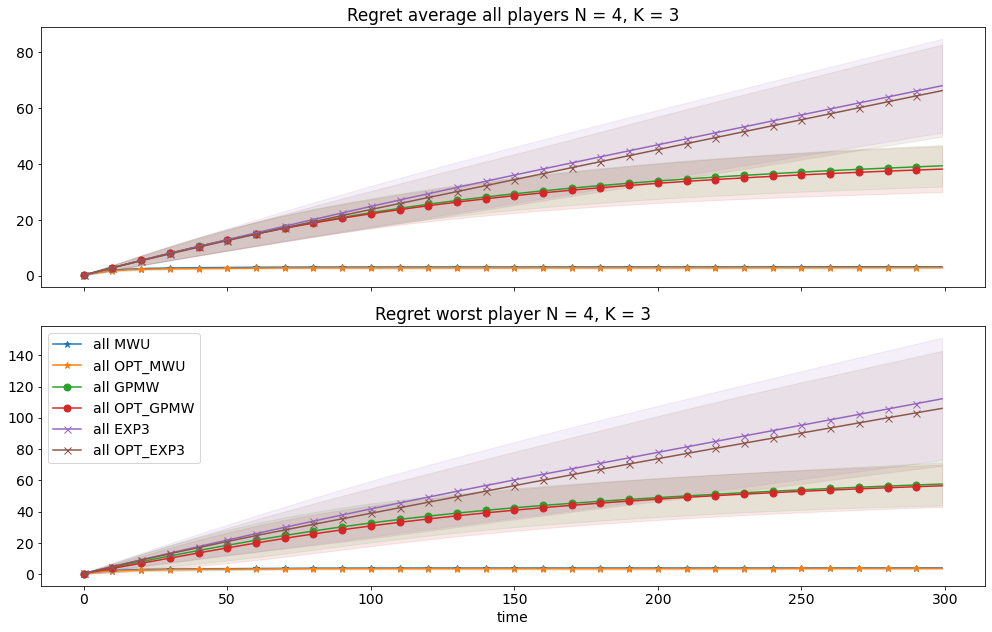

In [25]:
show('result')